# 3Channel_Kfold

### Load scripts

In [1]:
import time
t0 = time.time()

In [2]:
%%time
from script.util import *

run_name = get_run_name('SC_Iceberg_Classifier', 'CNN_3channel_Fit_VGG19_FineTune')
sample_submission = load_sample_submission()
y_data = load_y_data()
x_data, x_test = load_data()

cwd: D:\Kaggle\statoil-iceberg-classifier-challenge
input_path: D:\Kaggle\statoil-iceberg-classifier-challenge\input
log_path: D:\Kaggle\statoil-iceberg-classifier-challenge\log
model_path: D:\Kaggle\statoil-iceberg-classifier-challenge\model
output_path: D:\Kaggle\statoil-iceberg-classifier-challenge\output
run_name: SC_Iceberg_Classifier-CNN_3channel_Fit_VGG19_FineTune-20180111_004349
(8424, 2)
(1604,) 0 1 12936
(1604, 75, 75) 0.0 1.0 128
(1604, 75, 75) 0.0 1.0 128
(8424, 75, 75) 0.0 1.0 128
(8424, 75, 75) 0.0 1.0 128
(1604, 75, 75) 0.0210369138693 1.0 72180128
(8424, 75, 75) 0.0 1.0 379080128
(1604, 75, 75, 3) 0.0 1.0 216540144
(8424, 75, 75, 3) 0.0 1.0 1137240144
Wall time: 3.62 s


### Build model

In [3]:
# -*- coding: utf-8 -*-

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler, TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg19 import VGG19, preprocess_input

from sklearn.model_selection import train_test_split, KFold

Using TensorFlow backend.


In [4]:
import time
import sys
import os

import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss, accuracy_score

In [ ]:
def build_cnn(input_shape):
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(strides=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(strides=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(strides=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(units=1, activation='sigmoid'))

    # model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model
model = build_cnn(x_data.shape[1:])

Now beginning training for fold 0
Epoch 1/500
84/83 [==============================] - 36s 428ms/step - loss: 1.1384 - acc: 0.6146 - val_loss: 1.1652 - val_acc: 0.4963
Epoch 2/500
84/83 [==============================] - 30s 359ms/step - loss: 0.7865 - acc: 0.6741 - val_loss: 1.9415 - val_acc: 0.4963
Epoch 3/500
83/83 [============================>.] - ETA: 0s - loss: 0.6450 - acc: 0.6913
Epoch 00003: reducing learning rate to 9.999999747378752e-06.
84/83 [==============================] - 30s 357ms/step - loss: 0.6442 - acc: 0.6912 - val_loss: 1.9160 - val_acc: 0.4963
Epoch 4/500
84/83 [==============================] - 30s 357ms/step - loss: 0.5728 - acc: 0.6853 - val_loss: 2.1355 - val_acc: 0.4963
Epoch 00004: early stopping
268/268 [==============================] - 1s 5ms/step
Final loss: 2.1355, final accuracy: 0.4963
Val log_loss: 2.1355108088978136
Val log_loss: 1.5335732908057633
Index(['acc', 'loss', 'lr', 'val_acc', 'val_loss', 'epoch'], dtype='object')


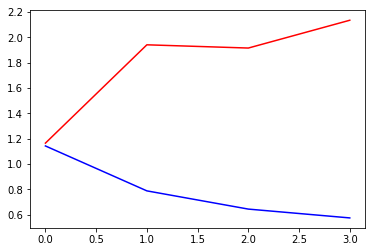

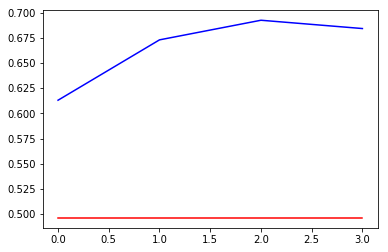

(8424, 1)
(8424, 1)
Now beginning training for fold 1
Epoch 1/500
84/83 [==============================] - 32s 387ms/step - loss: 0.6363 - acc: 0.6942 - val_loss: 2.6683 - val_acc: 0.4552
Epoch 2/500
45/83 [===============>..............] - ETA: 13s - loss: 0.5946 - acc: 0.6903

In [ ]:
def train_model(run_name, model, batch_size, epochs, n_fold, x_data, y_data, x_test):
    kf = KFold(n_splits=n_fold, random_state=2017)
    test_prob = np.zeros((x_test.shape[0], 1))
    for i, (train_index, val_index) in enumerate(kf.split(x_data)):
        print('Now beginning training for fold %s' % i)
        
        x_train = x_data[train_index]
        x_val = x_data[val_index]
        y_train = y_data[train_index]
        y_val = y_data[val_index]
#         print(train_index[:10])
#         print(train_index.shape)
#         print(val_index[:10])
#         print(val_index.shape)
        model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
        datagen = ImageDataGenerator(
            zoom_range = 0.2,
            rotation_range=20,
            horizontal_flip=True,
            vertical_flip=True,
            width_shift_range=0.2,
            height_shift_range=0.2
        )
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=3, verbose=1, min_delta=1e-4),
            ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, cooldown=1, verbose=1, min_lr=1e-7),
        ]
        steps_per_epoch = len(x_train) / batch_size
        hist = model.fit_generator(
            datagen.flow(x_train, y_train, batch_size=batch_size, shuffle=True, seed=2019),
            steps_per_epoch=steps_per_epoch,
            epochs=epochs, #1 for ETA, 0 for silent
            verbose=1,
            max_queue_size=128,
            callbacks=callbacks,
            workers=32,
            validation_data=(x_val, y_val)
        )
        
        
        # Valid model
        final_loss, final_acc = model.evaluate(x_val, y_val, verbose=1)
        print("Final loss: {0:.4f}, final accuracy: {1:.4f}".format(final_loss, final_acc))
        val_prob = model.predict(x_val)

        val_prob_limit = np.clip(val_prob, 0.00005, 0.99995)
        loss = log_loss(y_val, val_prob_limit)
        print('Val log_loss: {}'.format(loss))

        val_prob_limit = np.clip(val_prob_limit, 0.05, 0.95)
        loss = log_loss(y_val, val_prob_limit)
        print('Val log_loss: {}'.format(loss))

        acc_str = '{0:0>4}'.format(int(loss*10000))
        run_name_acc = '%s-%s-%s' % (run_name, i, acc_str)
        
        histories = pd.DataFrame(hist.history)
        histories['epoch'] = hist.epoch
        print(histories.columns)
        histories_file = os.path.join(model_path, 'fold_' + run_name_acc + str(i) + '.csv')
        histories.to_csv(histories_file, index=False)
        
        plt.plot(histories['loss'], color='b')
        plt.plot(histories['val_loss'], color='r')
        plt.show()
        plt.plot(histories['acc'], color='b')
        plt.plot(histories['val_acc'], color='r')
        plt.show()
        
        test_prob_fold = model.predict(x_test)
        print(test_prob_fold.shape)
        print(test_prob.shape)
        test_prob += test_prob_fold
        
        i += 0
    print('Finished training!')
    test_prob = test_prob / n_fold
    return test_prob

test_prob = train_model(run_name, model, 16, 500, 6, x_data, y_data, x_test)
describe(test_prob)

In [ ]:
cwd = os.getcwd()
input_path = os.path.join(cwd, 'input')
log_path = os.path.join(cwd, 'log')
model_path = os.path.join(cwd, 'model')
output_path = os.path.join(cwd, 'output')

print('cwd: %s' % cwd)
print('input_path: %s' % input_path)
print('log_path: %s' % log_path)
print('model_path: %s' % model_path)
print('output_path: %s' % output_path)
pred_file = os.path.join(output_path, run_name + '.csv')
print(pred_file)

In [ ]:
sample_submission['is_iceberg'] = test_prob
print(sample_submission[0:2])
print(sample_submission.shape)
sample_submission.to_csv(pred_file, index=False)

In [ ]:
t1 = time.time()
print('time cost: %.2f s' % (t1-t0))
print('Done!')